# Importing Images and masks

In [1]:
import os
if os.path.isdir('dice')==False:
    !unzip dice.zip

Archive:  dice.zip
 extracting: labelmap.txt            
 extracting: SegmentationClass/dice34.png  
 extracting: SegmentationClass/dice11.png  
 extracting: SegmentationClass/dice14.png  
 extracting: SegmentationClass/dice18.png  
 extracting: SegmentationClass/dice40.png  
 extracting: SegmentationClass/dice24.png  
 extracting: SegmentationClass/dice22.png  
 extracting: SegmentationClass/dice32.png  
 extracting: SegmentationClass/dice44.png  
 extracting: SegmentationClass/dice9.png  
 extracting: SegmentationClass/dice16.png  
 extracting: SegmentationClass/dice3.png  
 extracting: SegmentationClass/dice19.png  
 extracting: SegmentationClass/dice26.png  
 extracting: SegmentationClass/dice13.png  
 extracting: SegmentationClass/dice50.png  
 extracting: SegmentationClass/dice45.png  
 extracting: SegmentationClass/dice31.png  
 extracting: SegmentationClass/dice25.png  
 extracting: SegmentationClass/dice41.png  
 extracting: SegmentationClass/dice21.png  
 extracting: Segmenta

# Showing Examples

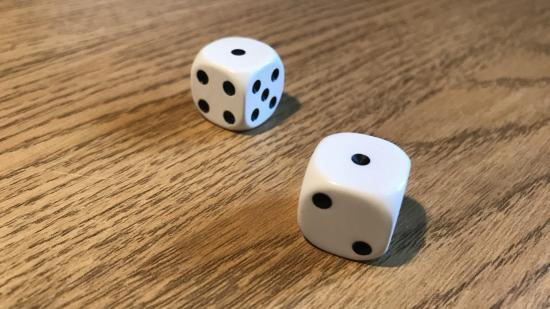

In [2]:
from PIL import Image
Image.open('JPEGImages/dice4.jpg')

In [3]:
os.mkdir("/content/masks")

In [4]:
#  Changing masks to grayscale
# why? I have used the suggested CVAT website to create masks and annotations, 
#unfortunately the masks generated weren't in greyscale. 
for i in range(1,51):
  path_rgb= "SegmentationObject/dice%d.png" % (i)
  img = Image.open(path_rgb).convert('L')
  path_gs= "masks/dice%d.png" % (i)
  img.save(path_gs)


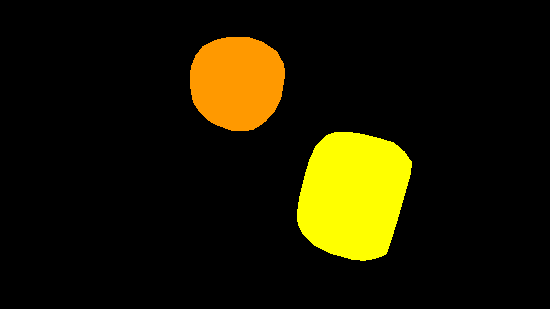

In [5]:
mask = Image.open('masks/dice4.png').convert("L")
#PIL Image.putpalette mostly work with P or L type

# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's add a color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

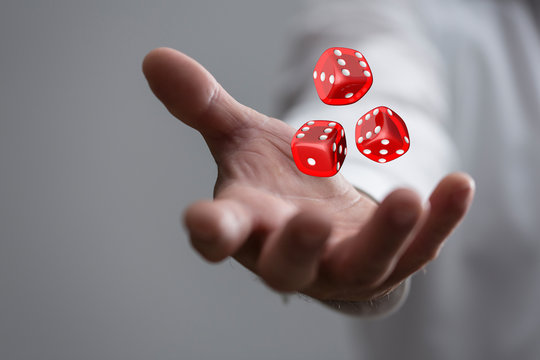

In [24]:
Image.open('JPEGImages/dice7.jpg')

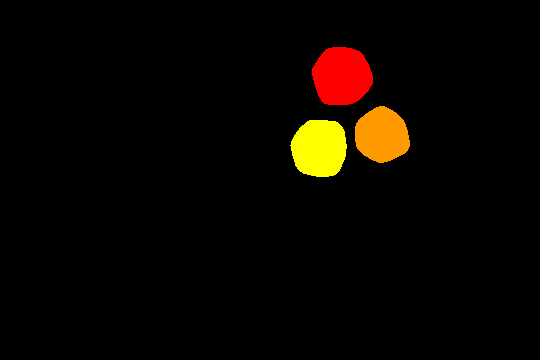

In [25]:
mask = Image.open('masks/dice7.png').convert("L")
#PIL Image.putpalette mostly work with P or L type

# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's add a color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

# Defining a Dataset class to load the data

In [6]:
import numpy as np
import torch
import torch.utils.data


class DiceDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "JPEGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "masks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "JPEGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)


        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes # the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H
        target["labels"] = labels # the label for each bounding box
        target["masks"] = masks # The segmentation masks for each one of the objects
        target["image_id"] = image_id # an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
        target["area"] = area # The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
        target["iscrowd"] = iscrowd #  instances with iscrowd=True will be ignored during evaluation.

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

# Defining Model Architecture

Modifiying the pre-trained head with a new one. 
We should modify the box_predictor and the mask_predictor to adapt to our dataset.

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# version dependent: pretrained=True or weights='DEFAULT'      
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

#Training the Model

Using some helper functions from PyTorch Github Repo.

In [8]:
if os.path.isdir('vision')==False:
    !git clone https://github.com/pytorch/vision.git
    %cd vision
    !git checkout v0.8.2
    !cp references/detection/utils.py ../
    !cp references/detection/transforms.py ../
    !cp references/detection/coco_eval.py ../
    !cp references/detection/engine.py ../
    !cp references/detection/coco_utils.py ../
    %cd ../
    cwd = os.getcwd()
    print(cwd)

Cloning into 'vision'...
remote: Enumerating objects: 255183, done.
remote: Counting objects: 100% (7862/7862), done.
remote: Compressing objects: 100% (487/487), done.
remote: Total 255183 (delta 7403), reused 7768 (delta 7359), pack-reused 247321
Receiving objects: 100% (255183/255183), 513.82 MiB | 17.55 MiB/s, done.
Resolving deltas: 100% (232304/232304), done.
/content/vision
Note: checking out 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)
/content
/content


Loading and transforming:

In [9]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

# use our dataset and defined transformations
dataset = DiceDataset('/content/', get_transform(train=True))
dataset_test = DiceDataset('/content/', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[0:40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[40:50])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Initializing model and optimizer:

In [10]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')

# our dataset has two classes only - background and dice
num_classes = 2

# get the model using our helper function
model = build_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

device: cuda:0


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

Training the model for 6 epochs.

In [11]:
# number of epochs
num_epochs = 6

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/20]  eta: 0:02:47  lr: 0.000268  loss: 6.7852 (6.7852)  loss_classifier: 0.3790 (0.3790)  loss_box_reg: 0.0826 (0.0826)  loss_mask: 6.3017 (6.3017)  loss_objectness: 0.0192 (0.0192)  loss_rpn_box_reg: 0.0028 (0.0028)  time: 8.3946  data: 0.6455  max mem: 2359
Epoch: [0]  [10/20]  eta: 0:00:13  lr: 0.002897  loss: 1.2878 (2.2829)  loss_classifier: 0.2570 (0.2598)  loss_box_reg: 0.2285 (0.2289)  loss_mask: 0.7257 (1.7618)  loss_objectness: 0.0236 (0.0278)  loss_rpn_box_reg: 0.0028 (0.0046)  time: 1.3070  data: 0.0687  max mem: 3725
Epoch: [0]  [19/20]  eta: 0:00:00  lr: 0.005000  loss: 0.9837 (1.6158)  loss_classifier: 0.1926 (0.2266)  loss_box_reg: 0.2403 (0.2655)  loss_mask: 0.4124 (1.0900)  loss_objectness: 0.0198 (0.0264)  loss_rpn_box_reg: 0.0043 (0.0073)  time: 0.9902  data: 0.0424  max mem: 3746
Epoch: [0] Total time: 0:00:19 (0.9948 s / it)
creating index...
index created!
Test:  [ 0/10]  eta: 0:00:11  model_time: 0.4497 (0.4497)  evaluator_time: 0.2357 (0.2357)  

#Save and Load model, weights

In [12]:
if os.path.isdir('maskrcnn_weights')==False: os.mkdir('maskrcnn_weights') 

In [13]:
torch.save(model, 'maskrcnn_weights/mask-rcnn-dice2.pt')

In [14]:
torch.save(model.state_dict(), 'maskrcnn_weights/mask-rcnn-dice_weights2.pt') 

In [15]:
model.load_state_dict(torch.load(os.getcwd()+'/maskrcnn_weights/mask-rcnn-dice_weights2.pt'))

<All keys matched successfully>

# Inference

Setting to evaluation mode:

In [16]:

model.eval()
CLASS_NAMES = ['__background__', 'dice']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

Defining a few util functions in order to visualize the results:

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import torchvision.transforms as T
import cv2
import random
import warnings
warnings.filterwarnings('ignore')

def get_coloured_mask(mask):
    """
    random_colour_masks
      parameters:
        - image - predicted masks
      method:
        - the masks of each predicted object is given random colour for visualization
    """
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

def get_prediction(img_path, confidence):
    """
    get_prediction
      parameters:
        - img_path - path of the input image
        - confidence - threshold to keep the prediction or not
      method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
          ie: eg. segment of cat is made 1 and rest of the image is made 0
    
    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    print("pred_t")
    print(pred_t)
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

def segment_instance(img_path, confidence=0.5, rect_th=2, text_size=1, text_th=2):
    """
    segment_instance
      parameters:
        - img_path - path to input image
        - confidence- confidence to keep the prediction or not
        - rect_th - rect thickness
        - text_size
        - text_th - text thickness
      method:
        - prediction is obtained by get_prediction
        - each mask is given random color
        - each mask is added to the image in the ration 1:0.8 with opencv
        - final output is displayed
    """
    masks, boxes, pred_cls = get_prediction(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
      rgb_mask = get_coloured_mask(masks[i])
      img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        
      #cv2.rectangle and cv2.putText version dependent
      pt1 = tuple([int(j) for j in boxes[i][0]])
      pt2 = tuple([int(j) for j in boxes[i][1]])  
      cv2.rectangle(img, pt1, pt2,color=(0, 255, 0), thickness=rect_th)
      cv2.putText(img,pred_cls[i], pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

Pulling some images from the internet 

**Example 1**

2022-11-25 15:48:24 URL:https://www.mediareferee.com/wp-content/uploads/2022/03/sic-bo.jpg [478225/478225] -> "testdice1.jpg" [1]
pred_t
1


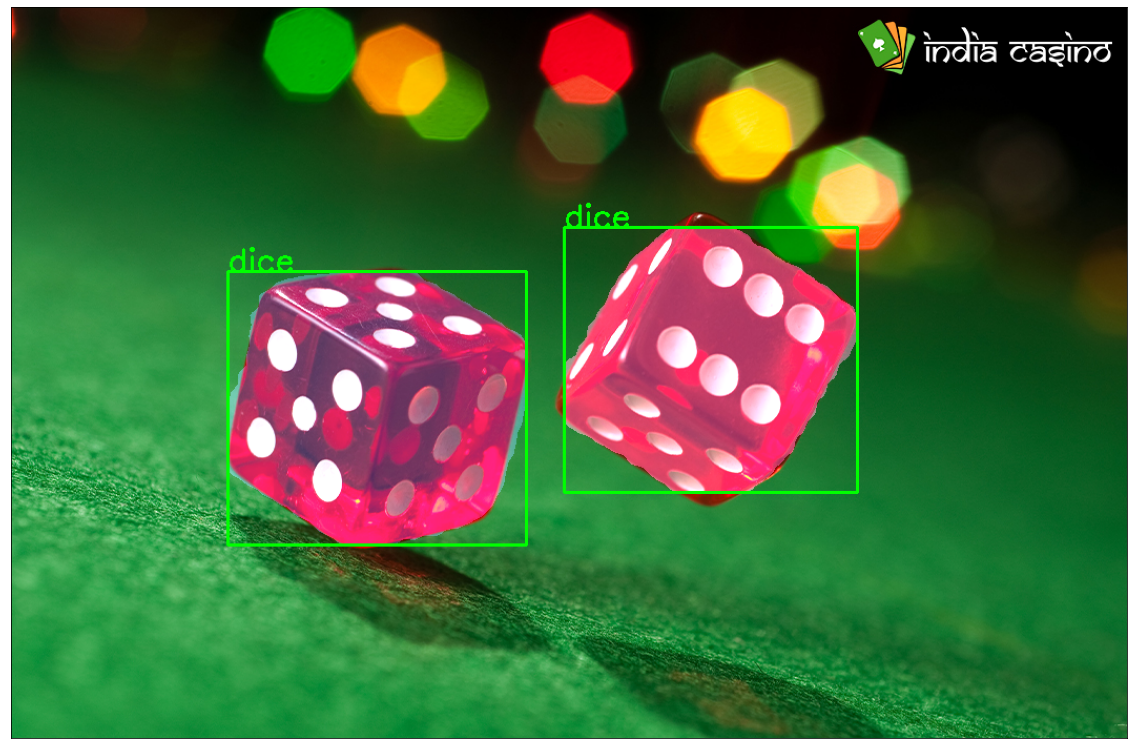

In [23]:
!wget -nv https://www.mediareferee.com/wp-content/uploads/2022/03/sic-bo.jpg --no-check-certificate -O testdice1.jpg
segment_instance('/content/testdice1.jpg', confidence=0.8)

**Example 2**

2022-11-25 15:32:02 URL:https://sofestive.com/wp-content/uploads/2020/12/DICE-GAME-GIFT-EXCHANGE-1.jpg [29255/29255] -> "testdice4.jpg" [1]
pred_t
4


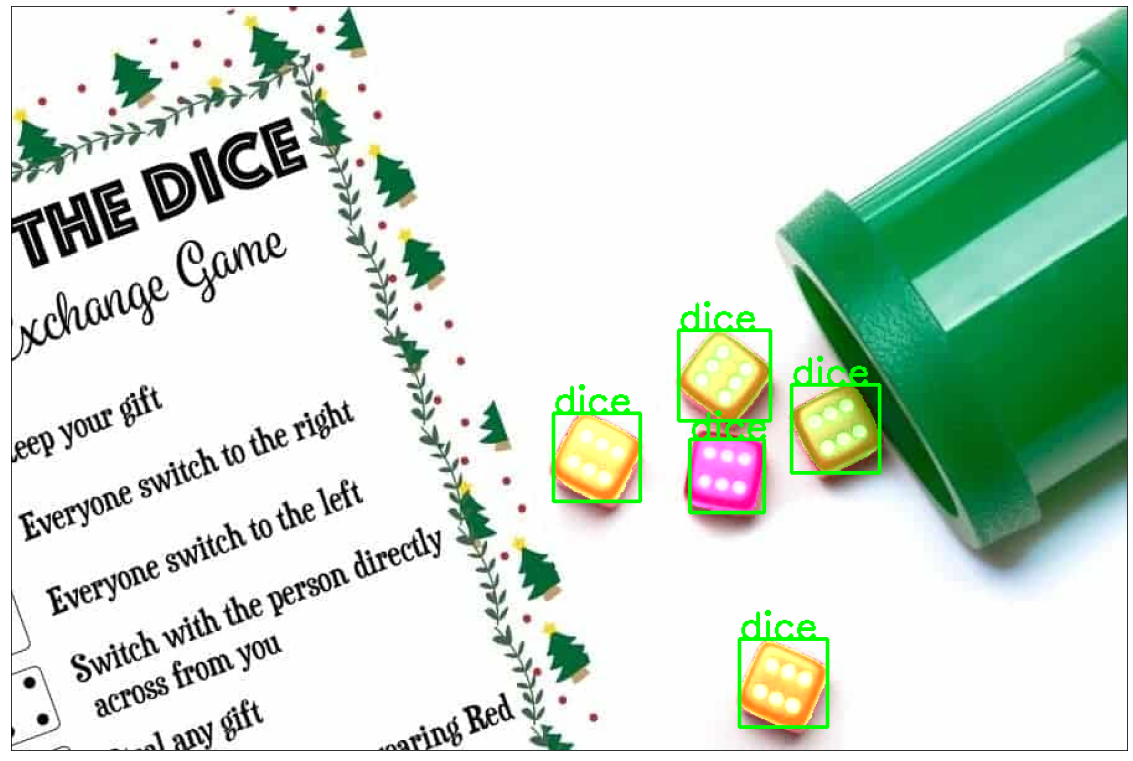

In [21]:
!wget -nv https://sofestive.com/wp-content/uploads/2020/12/DICE-GAME-GIFT-EXCHANGE-1.jpg --no-check-certificate -O testdice4.jpg
segment_instance('/content/testdice4.jpg', confidence=0.7)

**Example 3**

2022-11-25 15:32:13 URL:https://cdn.shopify.com/s/files/1/0534/7894/9056/products/edx_Soft_Dice_Pk2_75148_A.jpg?v=1662383322 [101443/101443] -> "testdice5.jpg" [1]
pred_t
1


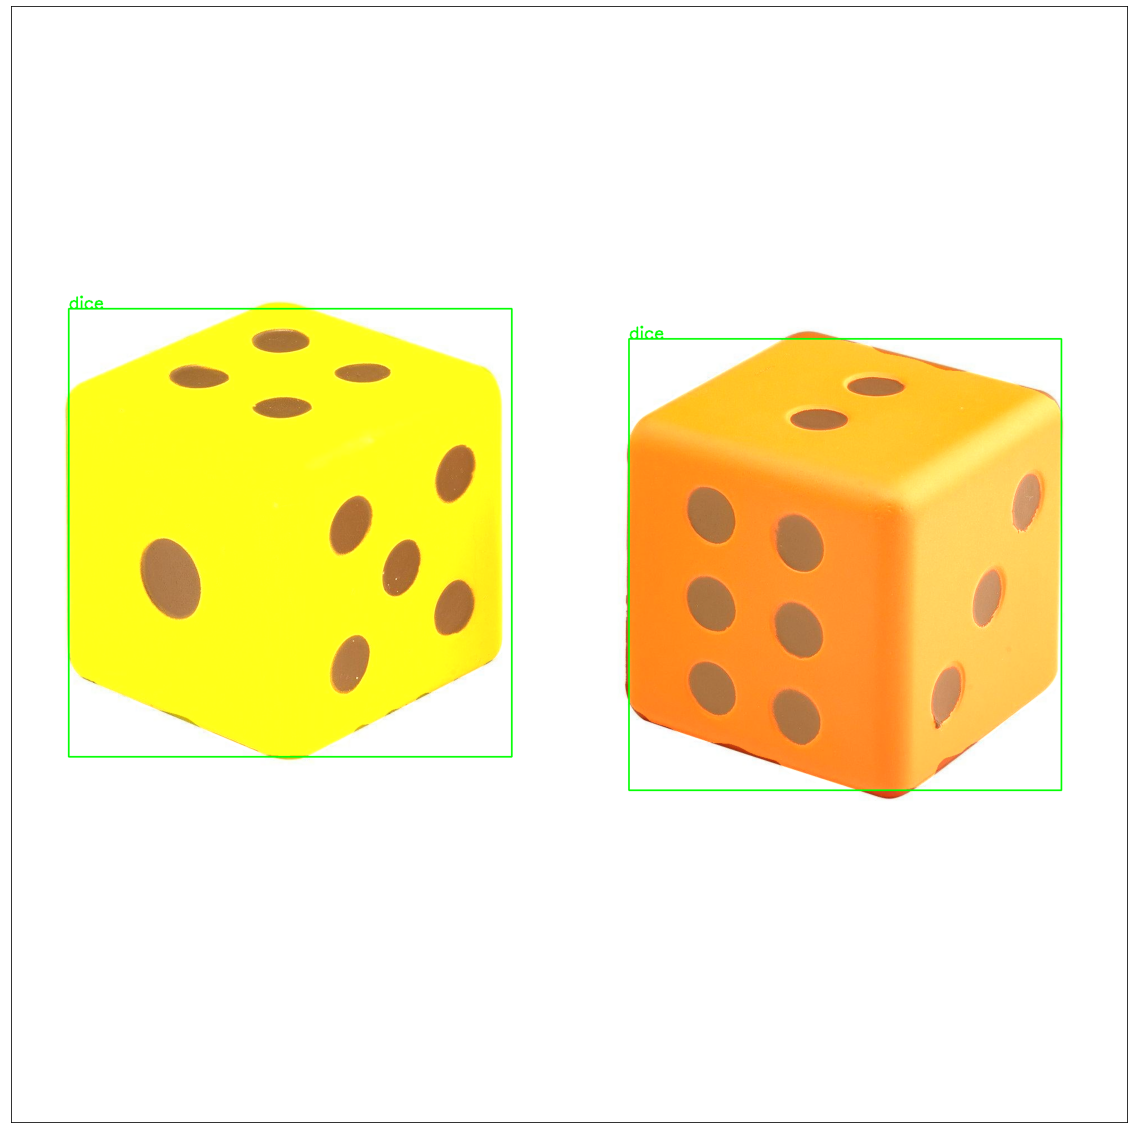

In [22]:
!wget -nv http://cdn.shopify.com/s/files/1/0534/7894/9056/products/edx_Soft_Dice_Pk2_75148_A.jpg?v=1662383322 --no-check-certificate -O testdice5.jpg
segment_instance('/content/testdice5.jpg', confidence=0.7)

# Conclusion

I am not completely satisfied with the results. I think the issue I have here is that I haven't picked good quality images for the training. There were many low quality images, and I realized a little too late that I need higher quality images for the training. As seen in the first example, the mask is not very accurate. 
If I had more time, I would choose higher quality images for training.